In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import multi_mnist as mln

In [2]:
@tf.function
def clean(imgs):
    num, h, w = imgs.shape
    img_data = tf.reshape(imgs,[num, -1])
    img_size = float(img_data.shape[1])
    means = tf.math.reduce_mean(img_data, axis=1)
    meansT = tf.reshape(means,[num, 1])
    stds = tf.math.reduce_std(img_data, axis=1)
    stdsT = tf.reshape(stds,[num, 1])
    adj_stds = tf.math.maximum(stdsT, 1.0/tf.math.sqrt(img_size))
    normalized = (img_data-meansT)/adj_stds
    normalized = tf.reshape(normalized,[num, h, w, 1])
    return normalized

In [3]:
def yolo_loss(y_true, y_pred):
    
    y_true_class = y_true[...,5:15]
    y_pred_class = y_pred[...,5:15]
    
    y_pred_xy   = y_pred[...,1:3]
    y_pred_wh   = y_pred[...,3:5]
    y_pred_conf = y_pred[...,0]

    y_true_xy   = y_true[...,1:3]
    y_true_wh   = y_true[...,3:5]
    y_true_conf = y_true[...,0]
    
    clss_loss  = tf.math.reduce_sum(
        tf.math.reduce_sum(
            tf.math.square(y_true_class - y_pred_class), axis=-1)*y_true_conf, axis=[-1,-2])
    xy_loss    = 5.*tf.math.reduce_sum(
        tf.math.reduce_sum(
            tf.math.square(y_true_xy - y_pred_xy),axis=-1)*y_true_conf, axis=[-1,-2])
    wh_loss    = 5.*tf.math.reduce_sum(
        tf.math.reduce_sum(
            tf.math.square(
                tf.math.sqrt(y_true_wh) - tf.math.sqrt(y_pred_wh)), axis=-1)*y_true_conf, axis=[-1,-2])
    
    conf_loss_noobj = 0.5*tf.math.reduce_sum(
        tf.math.square(y_pred_conf*(1-y_true_conf) - y_true_conf), axis=[-1,-2])
    conf_loss_obj = tf.math.reduce_sum(
        tf.math.square(y_pred_conf*(y_true_conf) - y_true_conf), axis=[-1,-2])
    
    total_loss = tf.math.reduce_mean(clss_loss + xy_loss + wh_loss + conf_loss_noobj + conf_loss_obj)
    
    return total_loss

In [4]:
model = Sequential()
model.add(layers.Conv2D(16, [3,3], activation=tf.nn.leaky_relu, input_shape=[200,200,1]))
model.add(layers.Conv2D(32, [3,3], activation=tf.nn.leaky_relu))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(16, [3,3], activation=tf.nn.leaky_relu))
model.add(layers.Conv2D(32, [3,3], activation=tf.nn.leaky_relu))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(375, activation='sigmoid'))
model.add(layers.Reshape((5,5,15)))
model.compile(optimizer=tf.keras.optimizers.Adam(0.002), loss=yolo_loss)

In [12]:
def gen_data(batch_size):
    while True:
        x, y = mln.get_data(batch_size)
        x = clean(x)
        yield (x, y)

In [14]:
generator = gen_data(64)
model.fit_generator(generator, steps_per_epoch=100)

ResourceExhaustedError: OOM when allocating tensor with shape[64,196,196,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv2d_1/BiasAdd-1-1-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[GroupCrossDeviceControlEdges_0/training/Adam/Adam/Const/_77]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_1907]

In [8]:
model.save_weights('yolo_test_1.h5')

In [11]:
model.load_weights('yolo_test_1.h5')

In [7]:
test_data, _ = mln.get_data(100)
test_data = test_data.astype(np.float32)
norm_data = clean(test_data)

In [12]:
out = model.predict(norm_data)

In [10]:
del model

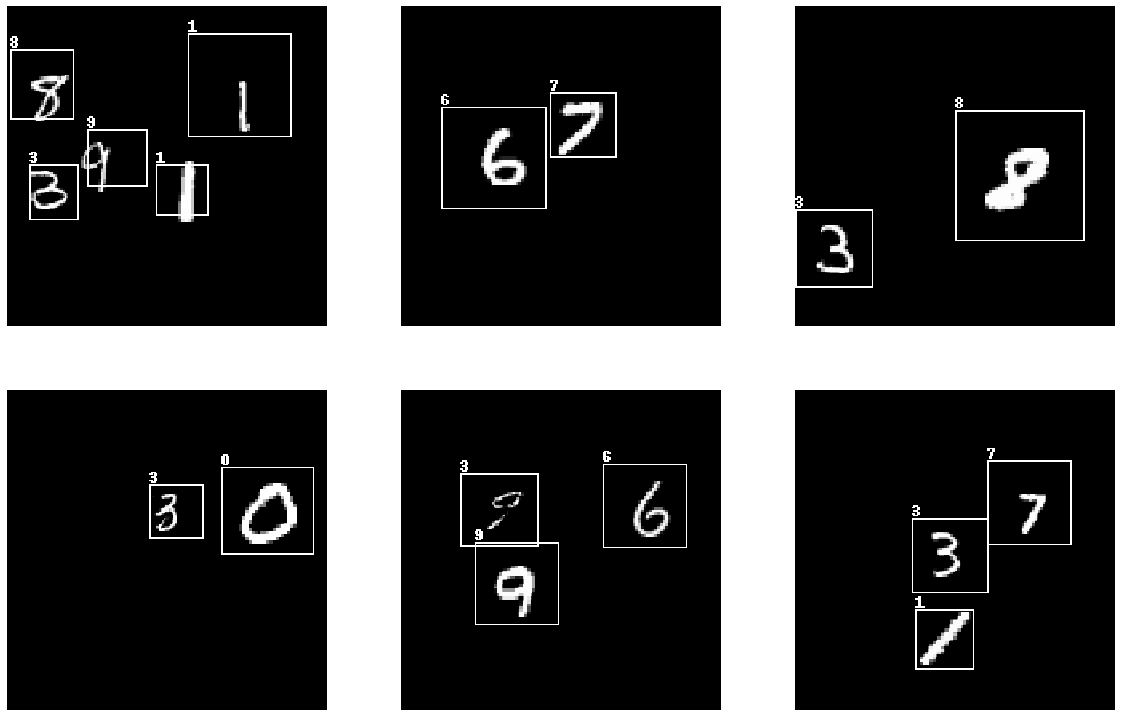

In [23]:
plt.figure(figsize=(20,20))
for cnt in range(6):
    img = Image.fromarray(test_data[cnt])
    draw = ImageDraw.Draw(img)
    div = 200/5

    out_box = np.copy(out[cnt])
    #out_box = non_max_supression(out_box)

    for x_index in range(5):
        for y_index in range(5):

            if out_box[x_index, y_index, 0] < 0.6:
                continue

            val = np.argmax(out[cnt,x_index,y_index,5:15])
            #print(val)
            x0,y0 = out[cnt,x_index,y_index,1]*div+x_index*div-0.5*out[cnt,x_index,y_index,4]*200, \
                        out[cnt,x_index,y_index,2]*div+y_index*div-0.5*out[cnt,x_index,y_index,3]*200
            x1,y1 = out[cnt,x_index,y_index,1]*div+x_index*div+0.5*out[cnt,x_index,y_index,4]*200, \
                        out[cnt,x_index,y_index,2]*div+y_index*div+0.5*out[cnt,x_index,y_index,3]*200
            draw.rectangle([(x0,y0),(x1,y1)],fill=None,outline=255)
            draw.text((x0,y0-10),'{}'.format(val), fill=255)

    del draw
    plt.subplot(3, 3, cnt+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.savefig('yolo.png', bbox_inches='tight')
plt.show()